# An open source software-defined BioMEMS SoC for early breast cancer detection

*"open in Colab" banner*

|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Lucca Reinehr Silva <br /> Email ID: luccareinehr@gmail.com|UFRGS, Brazil <br /> CentraleSupélec, France|Yes|No|

## Intro

Cancer is a large group of diseases where cells become disorganised and divide uncontrollably. This, however, does not happen silently. Cell growth on itself and how the body reacts to it create substances called **biomarkers**, which can be measured to detect cancer (in this case). Cancer biomarkers are usually found in body fluids such as blood, urine, or tissue samples, depending on what type of cancer is present [[1]](#ref1-biomarker).

The idea of this project is to leverage a resonating MEMS system to create a cancer biomarker sensor. To be more specific, the biomarker chosen is HER2 (*human epidermal growth factor receptor 2*), a protein that helps control the growth and division of cells. Around 20% of breast cancers have an overexpression of this protein, in which case they are denoted as "HER2-positive" [[2]](#ref2-HER2). This makes the cancer more agressive... but also detectable early by using HER2 as a biomarker.

### The MEMS device

To do that, we'll propose a two-way coupled resonator DETF (*double-ended tuning fork*) system, inspired by an article from Thiruvenkatanathan et al. [[3]](#ref3-coupledDETF). It has a relatively simple geometry, which will help when planning manufacturing (a big challenge in innovative MEMS designs), and is easier to model and couple with another resonator. The two resonators will be electrostatically coupled via a parallel-plate inbetween them. A top-view representation of this mechanical system is shown below.

![](./img/coupled-DETF-diagram.png)

*The moving parts of the two resonators are in blue and pink; in normal operation, they vibrate.*

Such a system can detect variations in the structure of each resonator. For instance, if both resonators are identical, they'll have the same resonant frequency (i.e., the frequency of maximum amplitude of oscillation). If there is a slight difference $\Delta M$ in their masses or in their stiffness $\Delta k$, the resonant frequency of both resonators will start to differ. Similarly, in closed-loop excitation with a constant frequency, their oscillation amplitudes will become non-equal.

Thus, by applying an organic coating that captures HER2 proteins in only one of the resonators, its mass will increase according to the number of proteins captured, which creates a difference in resonant frequency (or amplitude) between the resonators that can be measured electrically. For that, the system must be in continuous oscillation, so a closed-loop analog/digital circuitry will also be designed.

We'll envision to create a CMOS/MEMS system with monolithic integration (i.e., the electronic and mechanical parts are in the same silicon die). This way, such a device could not only be used to test patient samples for biomarkers in a lab, but also for in-situ installation of the SoC to detect cancer early in high-risk patients [[4]](#ref4-HER2serum) $-$ in this case, probably combined with an energy harvester for power supply.

## Code-the-chip

In [7]:
# Install dependencies
!pip install gdsfactory gdspy sfepy meshio

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 5.6 MB/s eta 0:00:0000:0100:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached meshio-5.3.4-py3-none-any.whl (167 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.9 MB/s eta 0:00:0000:0100:010m
  Using cached tables-3.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 MB 2.7 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 1.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 KB 2.1 MB/s eta 0:00:0000:0100:01
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached numexpr-2.8.7-cp310-cp310-many

### Step 1: Making our own PDK

The fabrication of MEMS devices usually requires a custom manufacturing process and PDK. The easiest way of making a MEMS sensor is to manufacture it in a separate die than its electronic support circuit, and connect them with wire bonding in package level. This wouldn't be as interesting for this project, so we're making a MEMS system with monolithic integration with CMOS, enabling to further miniaturize the device. There are several strategies possible for that, depending on the device characteristics and on available processes in the foundry.

Normally, once a foundry is chosen, the process layers are supplied according to their fabrication capabilities and norms when discussing the project. Since I wasn't able to find an open source PDK adapted to MEMS fabrication, we're going to make our own.

One possibility is to use a SOI (silicon-on-insulator) wafer for both CMOS and MEMS structures. They use largely available processes, have good dimensional control for mechanical structures, and good electrical isolation for the CMOS circuit [[5]](#ref5-cmosmems). However, since at the time of writing there is no mature open-source SOI CMOS PDK ([SKY90FD doesn't seem to be out yet](https://github.com/google/sky90fd-pdk)), we'll choose a different approach.

Based on the [SKY130](https://github.com/google/skywater-pdk) process, one can add a dry etching step (DRIE or "Bosch process") **after the CMOS circuit is ready** to create a **trench** in the silicon substrate needed for suspending MEMS devices. What's also interesting is that this Bosch process is mentioned as one of the capabilities of the SkyWater foundry [on their website](https://www.skywatertechnology.com/mems-photonics-and-custom/). In this "Bulk CMOS-MEMS Dry Process" [\[5](#ref5-cmosmems), [6\]](#ref6-driecmosmems), the mechanical structure is fabricated from a composition of CMOS layers (mainly oxide and metal layers) with the single-crystal silicon (SCS) substrate. A diagram depicting the post-CMOS procedure is presented below.

![](./img/post-cmos-drie.jpg)

*DRIE bulk CMOS-MEMS process flow for 4-metal-layer CMOS. (a) Backside silicon DRIE to define MEMS areas; (b) Front SiO2 etching; (c) Front-side silicon DRIE; (d) Front-side etching with lateral undercut.*

Therefore, we must modify the existing SKY130 PDK to consider additional layers for the MEMS part of the process. We're going to add a `trench` layer to define a through-hole structure in the substrate layer (fabricated via DRIE), similar to what is done in the former SOIMUMPs process [[7]](#ref7-science):

In [8]:
# Install sky130
!pip install sky130

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 2.7 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.3/817.3 KB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 KB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.4 MB/s eta 0:00:00
  Attempting uninstall: gdsfactory
    Found existing installation: gdsfactory 7.8.14
    Uninstalling gdsfactory-7.8.14:
      Successfully uninstalled gdsfactory-7.8.14


In [8]:
import gdsfactory as gf
from gdsfactory.typings import Layer
import sky130 # sky130 activates the pdk when imported
import sky130.layers as sl

sky130 = gf.get_active_pdk()

# create new layers
class CustomLayerMap(sl.LayerMap):
    trench: Layer = (98, 99)
    coating: Layer = (99, 99)

LAYER = CustomLayerMap()

2023-11-27 21:57:49.626 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/home/luccar/.local/lib/python3.10/site-packages/sky130/klayout/layers.yaml'.
/home/luccar/.local/lib/python3.10/site-packages/gdsfactory/pdk.py:267: UserWarning: The 'pdk.sparameters_path' is deprecated. Use gf.config.PATH instead
  warnings.warn(
2023-11-27 21:57:49.699 | WARNING  | gdsfactory.pdk:get_active_pdk:734 - No active PDK. Activating generic PDK.

2023-11-27 21:57:51.775 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/home/luccar/.local/lib/python3.10/site-packages/gdsfactory/generic_tech/layer_views.yaml'.
2023-11-27 21:57:51.779 | INFO     | gdsfactory.pdk:activate:307 - 'generic' PDK is now active
2023-11-27 21:57:51.782 | INFO     | gdsfactory.pdk:register_cells_yaml:395 - Registered cell 'sample'
2023-11-27 21:57:51.788 | INFO     | gdsfactory.pdk:activate:307 - 'sky130' PDK is now active
2023-1

In [9]:
from gdsfactory.technology import LayerView

# create layer views
trench_lv = LayerView(
    info=None,
 	layer=LAYER.trench,
 	layer_in_name=True,
 	frame_color="magenta",
 	fill_color="magenta",
 	frame_brightness=0,
 	fill_brightness=0,
 	hatch_pattern="dots",
 	line_style=None,
 	valid=True,
 	visible=True,
 	transparent=False,
 	width=1,
 	marked=False,
 	xfill=False,
 	animation=0,
 	group_members={}
)

her2coating_lv = LayerView(
    info=None,
 	layer=LAYER.coating,
 	layer_in_name=True,
 	frame_color="blue",
 	fill_color="blue",
 	frame_brightness=0,
 	fill_brightness=0,
 	hatch_pattern="solid",
 	line_style=None,
 	valid=True,
 	visible=True,
 	transparent=False,
 	width=1,
 	marked=False,
 	xfill=False,
 	animation=0,
 	group_members={}
)

biomems_pdk = gf.Pdk(
    name="custom_biomems_pdk",
    layers=dict(LAYER),
    base_pdk=sky130,
    sparameters_path=gf.config.sparameters_path,
    layer_views=sky130.layer_views,
)

biomems_pdk.layer_views.layer_views['trench'] = trench_lv
biomems_pdk.layer_views.layer_views['coating'] = her2coating_lv

biomems_pdk.activate()

/home/luccar/.local/lib/python3.10/site-packages/gdsfactory/pdk.py:267: UserWarning: The 'pdk.sparameters_path' is deprecated. Use gf.config.PATH instead
  warnings.warn(
2023-11-27 21:57:52.010 | INFO     | gdsfactory.pdk:activate:307 - 'custom_biomems_pdk' PDK is now active


Since one of the resonators will be coated with an organic compound that will capture the HER2 molecules, we've also added a `coating` layer to draw the coating.

The choice of compound for this layer and of its manufacturing process is perhaps the trickiest part in the design of our BioMEMS device, and is beyond the scope of this notebook. However, some hints will be given to show that it may be feasible. There are several binding agents that have been studied for HER2, such as anti-HER2 antibodies [[8]](#ref8-her2antibodies) and a complex structure comprised of Affibody-biotin compounds and coated quantum dots [[9]](#ref9-quantumdot). To immobilize these compounds in the silicon, layer-by-layer deposition could perhaps be used [[10]](#ref10-layerbylayer).

### Step 2: Designing the coupled resonators

For easy device parametrization and integration with GDS files generated by other tools, we'll use gdsfactory for the MEMS design.

First, let's create a single double-ended-tuning-fork (DETF) structure:

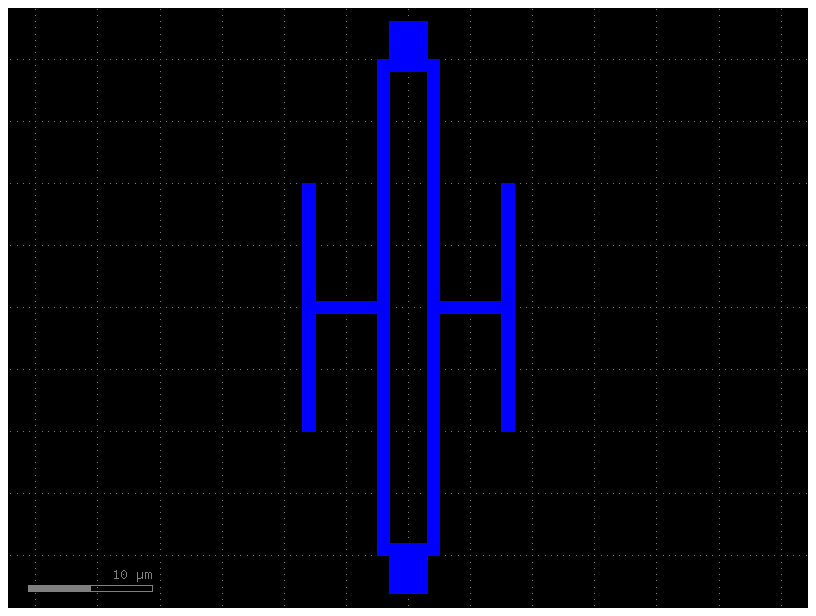

In [10]:
from shapely.geometry.polygon import Polygon
from shapely.affinity import scale

def detf(length, width, thickness, layer):
    c = gf.Component("detf")

    # tuning fork prong
    rect0 = Polygon([(-length/2, -width/2), (-length/2, width/2), (length/2, width/2), (length/2, -width/2)])
    rect1 = Polygon([(-length/2+thickness, -width/2+thickness), (-length/2+thickness, width/2-thickness), (length/2-thickness, width/2-thickness), (length/2-thickness, -width/2+thickness)])

    rect0not1 = rect0 - rect1
    c.add_polygon(rect0not1, layer=layer)

    # anchor
    base_thickness = 3*thickness
    base_rect = Polygon([(-base_thickness/2, -width/2-base_thickness),(-base_thickness/2, -width/2),(base_thickness/2, -width/2),(base_thickness/2, -width/2-base_thickness)])
    base_rect_mirr = scale(base_rect, xfact=1, yfact=-1, origin=(0, 0)) # mirror
    c.add_polygon(base_rect.union(base_rect_mirr), layer=layer)

    # drive electrode arm
    drive_arm_length = length
    drive_elec_arm = Polygon([(-length/2, -thickness/2),(-length/2, thickness/2),(-length/2-drive_arm_length, thickness/2),(-length/2-drive_arm_length, -thickness/2)])
    drive_elec_arm_mirr = scale(drive_elec_arm, xfact=-1, yfact=1, origin=(0, 0)) # mirror
    c.add_polygon(drive_elec_arm.union(drive_elec_arm_mirr), layer=layer)

    # drive electrode
    drive_elec_width = width/2
    drive_elec_origin = -length/2-drive_arm_length
    drive_elec = Polygon([(drive_elec_origin,-drive_elec_width/2),(drive_elec_origin, drive_elec_width/2),(drive_elec_origin-thickness, drive_elec_width/2),(drive_elec_origin-thickness, -drive_elec_width/2)])
    drive_elec_mirr = scale(drive_elec, xfact=-1, yfact=1, origin=(0,0)) # mirror
    c.add_polygon(drive_elec.union(drive_elec_mirr), layer=layer)
    
    return c

length = 5
width = 40
thickness = 1

detf(length, width, thickness, biomems_pdk.layers['coating']).plot()

Now, let's duplicate it and create the drive electrode structures (where the varying voltage from the control loop is applied), fixed in the silicon. Because of our chosen manufacturing strategy, we must draw structures for all layers from the silicon substrate up to metal #5:

In [12]:
def drive_electrode(length, width, layer):
    c = gf.Component("drive_electrode")

    drive_elec_fixed = Polygon([(-length/2, -width/2),(-length/2, width/2),(length/2, width/2),(length/2, -width/2)])
    c.add_polygon(drive_elec_fixed, layer=layer)
    
    return c

def two_way_coupled_resonator(detf, detf_length, coupling_gap, drive_electrode, drive_elec_length):
    c = gf.Component("two_way_coupled_resonator")
    
    res1 = c.add_ref(detf)
    res2 = c.add_ref(detf)
    res1.move([-detf_length/2 - coupling_gap/2, 0])
    res2.move([detf_length/2 + coupling_gap/2 ,0])

    elec1 = c.add_ref(drive_electrode)
    elec2 = c.add_ref(drive_electrode)
    elec1.move([-detf_length - drive_elec_length/2 - coupling_gap, 0])
    elec2.move([detf_length + drive_elec_length/2 + coupling_gap, 0])

    return c

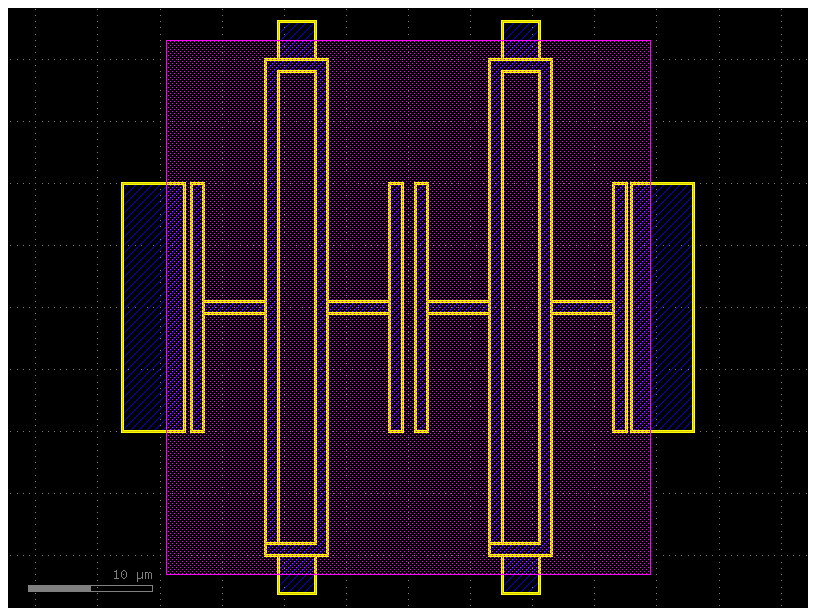

In [15]:
mems_layers = ['met1drawing', 'viadrawing', 'met2drawing', 'via2drawing', 'met3drawing', 'via3drawing',
               'met4drawing', 'via4drawing', 'met5drawing']
fixed_drive_elec_length = 5
coupling_gap = 1

drive_elec_length = fixed_drive_elec_length
total_detf_length = length + 2*length + 2*thickness # length + (drive_arms) length + (drive_electrodes) width
total_detf_width = width + 2*(3*thickness) # width + (anchors) width

coupled_resonators = gf.Component("coupled_resonators_all_layers")

# create CMOS process layers
for layer in mems_layers:
    resonator = detf(length, width, thickness, biomems_pdk.layers[layer])
    drive_elec = drive_electrode(fixed_drive_elec_length, width/2, biomems_pdk.layers[layer])
    
    coupled_resonators.add_ref(
        two_way_coupled_resonator(resonator, total_detf_length, coupling_gap, drive_elec, drive_elec_length)
    )

# create silicon subtrate trench
trench_rect = gf.components.rectangle(size=(total_detf_length*2+drive_elec_length, total_detf_width-3*thickness), layer=biomems_pdk.layers['trench'])
trench_rect_ref = coupled_resonators.add_ref(trench_rect)
trench_rect_ref.move([-total_detf_length-drive_elec_length/2,-total_detf_width/2+3*thickness/2])

coupled_resonators.plot()

Let's now add the coating necessary to bind HER2 molecules in one of the resonators:

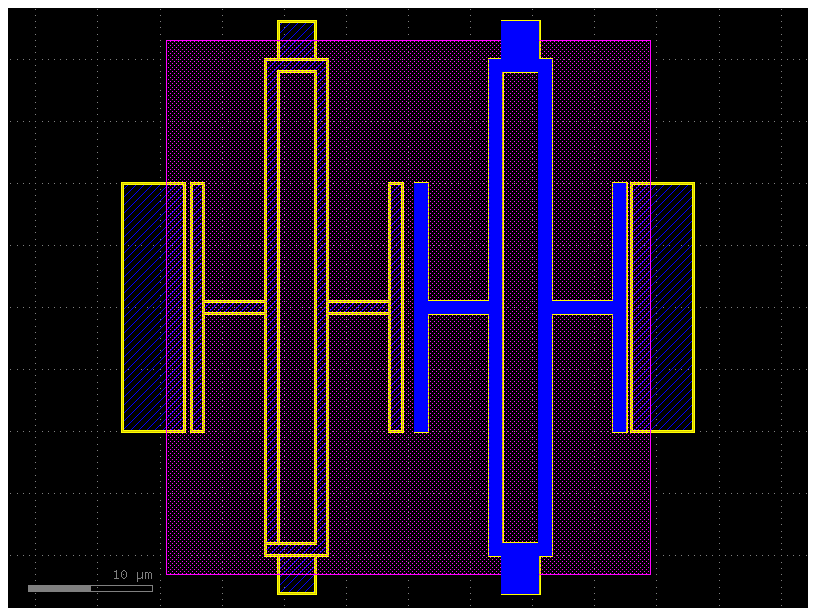

In [16]:
res_coating = detf(length, width, thickness, biomems_pdk.layers['coating'])
res_coating_ref = coupled_resonators.add_ref(res_coating)
res_coating_ref.move([total_detf_length/2 + coupling_gap/2 ,0])

coupled_resonators.plot()

Now finish by saving the GDSII file.

In [15]:
coupled_resonators.write_gds("coupled_resonators.gds")

2023-11-26 19:59:26.485 | INFO     | gdsfactory.component:_write_library:1913 - Wrote to 'coupled_resonators.gds'


PosixPath('coupled_resonators.gds')

### Step 3: Simulating the mechanical microsystem

AttributeError: 'GdsLibrary' object has no attribute 'cell_dict'

### Step 4: Designing the analog/digital front-end

### Step 5: Generating the front-end physical layout

### Step 6: Integrating the systems

## Conclusion

## References

<a id='ref1-biomarker'></a>
[1] https://www.cancer.org/cancer/diagnosis-staging/tests/biomarker-tests.html

<a id='ref2-HER2'></a>
[2] https://www.mayoclinic.org/breast-cancer/expert-answers/faq-20058066

<a id='ref3-coupledDETF'></a>
[3] https://ieeexplore.ieee.org/document/5210140/

<a id='ref4-HER2serum'></a>
[4] https://bmccancer.biomedcentral.com/articles/10.1186/s12885-020-07545-2

<a id='ref5-cmosmems'></a>
[5] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6189935/

<a id='ref6-driecmosmems'></a>
[6] https://www.frontiersin.org/articles/10.3389/fmech.2022.894484/full

<a id='ref7-science'></a>
[7] https://science.xyz/docs/d/mems-soi/index

<a id='ref8-her2antibodies'></a>
[8] https://www.frontiersin.org/journals/oncology/articles/10.3389/fonc.2022.917439/full

<a id='ref9-quantumdot'></a>
[9] https://molmed.biomedcentral.com/articles/10.1186/s10020-019-0108-z

<a id='ref10-layerbylayer'></a>
[10] https://novapublishers.com/shop/layer-by-layer-deposition-development-and-applications/ (put the book)

## Acknowledgements?

my advisor in CentraleSupélec, with whom I learned a lot about MEMS design and fabrication techniques
my partner, who is studying medicine and helped me with biophysics and biochemistry intrinsics
the open source silicon community, that is creating contest opportunities like this and changing the way engineers learn and use microelectronics for a better and more inclusive field